In [1]:
import kaggle
import zipfile
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from kaggle.api.kaggle_api_extended import KaggleApi
from sklearn.metrics import precision_recall_fscore_support as score
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By

In [3]:
api = KaggleApi()
api.authenticate()

In [43]:
api.dataset_download_files('fanconic/skin-cancer-malignant-vs-benign')

In [ ]:
with ZipFile('skin-cancer-malignant-vs-benign.zip', 'r') as zipObj:
    zipObj.extractall()
print(os.listdir('data/'))

In [4]:
benign_train_dir = 'data/train/benign'
malignant_train_dir = 'data/train/malignant'

benign_test_dir = 'data/test/benign'
malignant_test_dir = 'data/test/malignant'

In [5]:
read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

#Loading and converting Training Pictures to Array

ims_benign = [read(os.path.join(benign_train_dir, filename)) for filename in os.listdir(benign_train_dir)]
x_benign_train = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(malignant_train_dir, filename)) for filename in os.listdir(malignant_train_dir)]
x_malignant_train = np.array(ims_malignant, dtype='uint8')

#Loading and converting Testing Pictures to Array
ims_benign = [read(os.path.join(benign_test_dir, filename)) for filename in os.listdir(benign_test_dir)]
x_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(malignant_test_dir, filename)) for filename in os.listdir(malignant_test_dir)]
x_malignant_test = np.array(ims_malignant, dtype='uint8')


In [6]:
# Creating Labels
y_benign_train = np.zeros(x_benign_train.shape[0])
y_malignant_train = np.ones(x_malignant_train.shape[0])

y_benign_test = np.zeros(x_benign_test.shape[0])
y_malignant_test = np.ones(x_malignant_test.shape[0])



In [7]:
# Merge Labels and Pictures
x_train = np.concatenate((x_benign_train, x_malignant_train), axis = 0)
y_train = np.concatenate((y_benign_train, y_malignant_train), axis = 0)

x_test = np.concatenate((x_benign_test, x_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

In [8]:
# Shuffle arrays
s = np.arange(x_train.shape[0])
np.random.shuffle(s)
x_train = x_train[s]
y_train = y_train[s]

s = np.arange(x_test.shape[0])
np.random.shuffle(s)
x_test = x_test[s]
y_test = y_test[s]

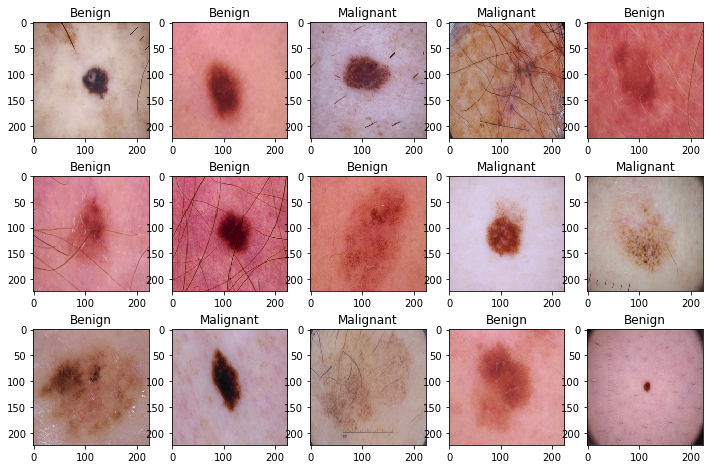

In [9]:
# Display first 15 images with their classification
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [10]:
x_train = x_train/255.
x_test = x_test/255.

In [11]:
# Split Labels in two categories ( malignant, benign)
# 1/0 = benign
# 0/1 = malignant
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

In [12]:
# Defining Layers
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224,224,3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation = 'softmax')
])


In [13]:
# model compiling
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 128)               2

In [15]:
model.fit(x_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
66/66 [==============================] - 220s 3s/step - loss: 0.9619 - accuracy: 0.5804 - val_loss: 0.5897 - val_accuracy: 0.7727
Epoch 2/10
66/66 [==============================] - 249s 4s/step - loss: 0.5508 - accuracy: 0.7131 - val_loss: 0.4065 - val_accuracy: 0.8011
Epoch 3/10
66/66 [==============================] - 290s 4s/step - loss: 0.5043 - accuracy: 0.7449 - val_loss: 0.5693 - val_accuracy: 0.7273
Epoch 4/10
66/66 [==============================] - 233s 4s/step - loss: 0.4505 - accuracy: 0.7824 - val_loss: 0.4313 - val_accuracy: 0.7727
Epoch 5/10
66/66 [==============================] - 234s 4s/step - loss: 0.4100 - accuracy: 0.7942 - val_loss: 0.3784 - val_accuracy: 0.8182
Epoch 6/10
66/66 [==============================] - 231s 4s/step - loss: 0.3509 - accuracy: 0.8246 - val_loss: 0.3939 - val_accuracy: 0.8163
Epoch 7/10
66/66 [==============================] - 232s 4s/step - loss: 0.3125 - accuracy: 0.8454 - val_loss: 0.3712 - val_accuracy: 0.8295
Epoch 8/10
66

In [16]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)
print('\nTest loss:', test_loss)

21/21 - 17s - loss: 0.4206 - accuracy: 0.8106 - 17s/epoch - 807ms/step

Test accuracy: 0.810606062412262

Test loss: 0.42064616084098816


In [29]:
predictions = model.predict(x_test)
print(predictions)

[[9.98139977e-01 1.86003128e-03]
 [8.89816105e-01 1.10183895e-01]
 [6.58767343e-01 3.41232687e-01]
 ...
 [8.99129827e-03 9.91008699e-01]
 [9.99975204e-01 2.48042870e-05]
 [3.02683907e-06 9.99997020e-01]]


In [31]:
# Split labels of prediction in two categories ( malignant, benign)
# 1/0 = benign
# 0/1 = malignant
predictions=np.argmax(predictions, axis=1)
predictions = to_categorical(predictions, num_classes= 2)

# Calculate precision, recall, fscore
precision, recall, fscore, support = score(y_test, predictions)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))

precision: [0.80678851 0.81588448]
recall: [0.85833333 0.75333333]
fscore: [0.83176312 0.78336222]
support: [360 300]


Label [1. 0.]
Prediction [9.9996829e-01 3.1748856e-05]


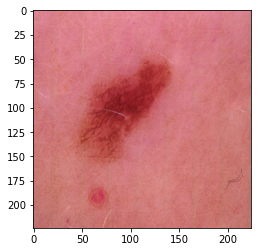

In [18]:
i = 10
# 1/0 = benign
# 0/1 = malignant
plt.imshow(x_test[i], interpolation='nearest')
print('Label' , y_test[i])
print('Prediction' , predictions[i])

In [24]:
# Set Options for Selenium
options = Options()
options.headless = True
options.add_argument("--window-size=1920,1200")

# Set ChromeDriver
DRIVER_PATH = 'chromedriver_win32/chromedriver.exe'
driver = webdriver.Chrome(options=options, executable_path=DRIVER_PATH)

# Get url and the correct element for img
driver.get('https://www.cancer.org/cancer/skin-cancer/skin-cancer-image-gallery.html?filter=Basal%20Cell%20Carcinoma,Kaposi%20Sarcoma,Melanoma,Merkel%20Cell%20Carcinoma,Skin%20Lymphoma,Squamous%20Cell%20Carcinoma')
card_header = driver.find_elements(By.CLASS_NAME, 'card-header')

# For Loop to get 5 images from the element (WebScraping)
for i in range(0, 5):
    try:
        img = card_header[i].find_element(By.TAG_NAME, 'img')
        img.screenshot('download_location/' + 
                       'cancer_' +  str(i) + '.jpg')
        time.sleep(0.2)
    except:
        continue
driver.close()


<ipython-input-24-13f7c9b46240>:11: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(options=options, executable_path=DRIVER_PATH)


In [19]:
path = "download_location/"
dirs = os.listdir(path)

# For Loop resize the image to fit the model
for item in dirs:
    if os.path.isfile(path+item):
        img = image.load_img(path+item, target_size=(224, 224))
        img_tensor = image.img_to_array(img)
        img_tensor = np.expand_dims(img_tensor, axis=0)
        img_tensor /= 255.
        predictions = model.predict(img_tensor)
        print(predictions[0])



[0.34443098 0.65556896]
[0.2668716 0.7331284]
[1.8942577e-10 1.0000000e+00]
[0. 1.]
[2.1768471e-08 1.0000000e+00]
